In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

### Gradient boosting

Gradient boosting is a powerful machine learning technique used for regression and classification tasks. It is an ensemble learning method, which means it combines the predictions from multiple machine learning algorithms to make more accurate predictions than any individual model. Specifically, gradient boosting builds multiple decision trees sequentially, where each tree corrects the errors of its predecessor. This is done by fitting the new tree to the residual errors of the previous one, essentially directing the new tree to focus on the hardest-to-predict observations. This sequential correction of errors makes gradient boosting a highly adaptive and effective technique for a wide variety of problems. The 'gradient' in gradient boosting refers to the fact that the algorithm uses gradient descent to minimize the loss function, optimizing the model's performance.

Let's walk through a basic regression example using decision trees as the base predictors (although gradient boosting is also highly effective for regression tasks). This is known as Gradient Tree Boosting or Gradient Boosted Regression Trees. First, a DecisionTreeRegressor is fitted to the training set.

In [2]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [4]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:



In [5]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [6]:
X_new = np.array([[0.8]])

In [7]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [8]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

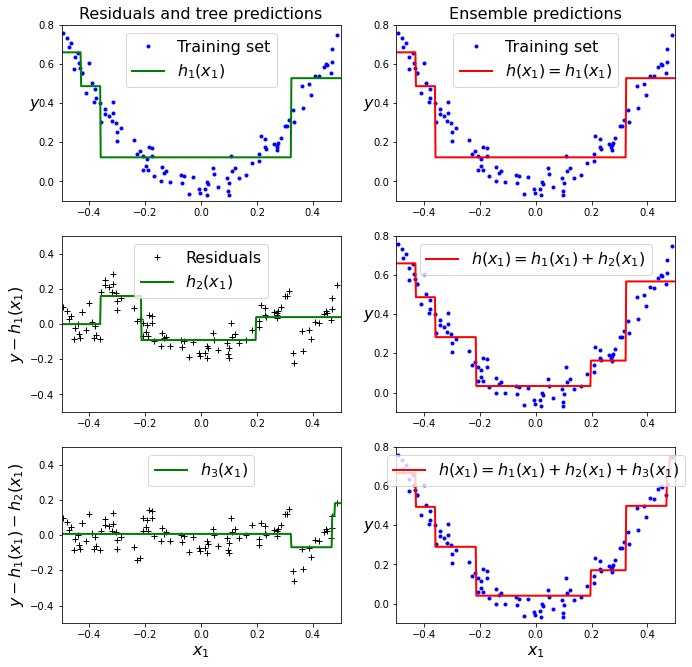

In [9]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Now let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

In [10]:
# Load Titanic dataset into a pandas dataframe and drop incomplete rows
titanic = pd.read_csv('titanic.csv').dropna()    # Throw away any incomplete rows

titanic.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [11]:
titanic.shape

(183, 12)

In [12]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 1 to 889
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  183 non-null    int64  
 1   Survived     183 non-null    int64  
 2   Pclass       183 non-null    int64  
 3   Name         183 non-null    object 
 4   Sex          183 non-null    object 
 5   Age          183 non-null    float64
 6   SibSp        183 non-null    int64  
 7   Parch        183 non-null    int64  
 8   Ticket       183 non-null    object 
 9   Fare         183 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     183 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 18.6+ KB


We are interested in knowing the levels of the categorical data

In [13]:

dfo = titanic.select_dtypes(include=['object'])

# Get levels count for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn


,VarName,LevelsCount
0,Name,183
1,Sex,2
2,Ticket,127
3,Cabin,133
4,Embarked,3


In [14]:
# Select categorical columns
cat_cols = titanic.select_dtypes(include=['object']).columns

# Iterate over each categorical column and prints its name followed by its unique values 
for col in cat_cols:
    print(col + ": " + str(titanic[col].unique()))

Name: ['Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Futrelle, Mrs. Jacques Heath (Lily May Peel)' 'McCarthy, Mr. Timothy J'
 'Sandstrom, Miss. Marguerite Rut' 'Bonnell, Miss. Elizabeth'
 'Beesley, Mr. Lawrence' 'Sloper, Mr. William Thompson'
 'Fortune, Mr. Charles Alexander'
 'Harper, Mrs. Henry Sleeper (Myna Haxtun)'
 'Ostby, Mr. Engelhart Cornelius' 'Harris, Mr. Henry Birkhardt'
 'Nye, Mrs. (Elizabeth Ramell)' 'Moen, Mr. Sigurd Hansen'
 'Fortune, Miss. Mabel Helen' 'Chaffee, Mr. Herbert Fuller'
 'Goldschmidt, Mr. George B' 'Greenfield, Mr. William Bertram'
 'White, Mr. Richard Frasar' 'Porter, Mr. Walter Chamberlain'
 'Baxter, Mr. Quigg Edmond' 'Webber, Miss. Susan'
 'White, Mr. Percival Wayland' 'Newsom, Miss. Helen Monypeny'
 'Futrelle, Mr. Jacques Heath' 'Giglio, Mr. Victor'
 'Navratil, Mr. Michel ("Louis M Hoffman")'
 'Pears, Mrs. Thomas (Edith Wearne)' 'Van der hoef, Mr. Wyckoff'
 'Smith, Mr. James Clinch' 'Isham, Miss. Ann Elizabeth'
 'Becker, Master. Richard F' 'Nav

Now we shall create dummy features for the categorical features and add those to our dataframe, removing the original categorical columns from the dataframe

In [15]:
dfo = titanic.select_dtypes(include=['object']) 

titanic = pd.DataFrame(titanic.drop(dfo.columns,axis =1)).merge(pd.get_dummies(dfo.drop(['Name','Cabin','Ticket'],axis =1)),left_index=True,right_index=True).drop(['PassengerId'],axis =1)


In [16]:
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
6,0,1,54.0,0,0,51.8625,0,1,0,0,1
10,1,3,4.0,1,1,16.7000,1,0,0,0,1
11,1,1,58.0,0,0,26.5500,1,0,0,0,1


In [17]:
titanic.shape

(183, 11)

The null values for each column in the dataframe:

In [18]:
titanic.isnull().sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [19]:
# Create the X and y matrices from the dataframe, where y = df.Survived
X = titanic.drop('Survived', axis=1)
y = titanic.Survived

In [20]:
# Apply the standard scaler to the X matrix
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [21]:
# Split the X_scaled and y into 75/25 training and testing data subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

In [22]:
# Run the cell below to test multiple learning rates in the gradient boosting classifier
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.40f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.40f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.7372262773722627615669011902355123311281
Accuracy score (validation): 0.6086956521739130820947139000054448843002

Learning rate:  0.1
Accuracy score (training): 0.8102189781021897907464790478115901350975
Accuracy score (validation): 0.6956521739130434589526430499972775578499

Learning rate:  0.25
Accuracy score (training): 0.8540145985401459416408442848478443920612
Accuracy score (validation): 0.7391304347826086473816076249931938946247

Learning rate:  0.5
Accuracy score (training): 0.8686131386861314362946018263755831867456
Accuracy score (validation): 0.7391304347826086473816076249931938946247

Learning rate:  0.75
Accuracy score (training): 0.8905109489051095117417844448937103152275
Accuracy score (validation): 0.7391304347826086473816076249931938946247

Learning rate:  1
Accuracy score (training): 0.9270072992700729708204221424239221960306
Accuracy score (validation): 0.7173913043478260531671253374952357262373



The best learning rate seems to be 0.25.

The reason is that this learning rate achieves the highest accuracy score on the validation set (0.739), which indicates that the model is generalizing well to new data. Other learning rates (0.5 and 0.75) achieve a similar validation accuracy score, but they have higher training accuracy scores, which suggest overfitting. Therefore, it is recommended to use the learning rate that achieves the highest validation accuracy score while avoiding overfitting, which in this case is 0.25.

In [23]:
# Apply the best learning rate to the model fit and predict on the testing set
gb_best = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.25, max_features=2, max_depth = 2, random_state = 0)
gb_best.fit(X_train, y_train)
y_pred = gb_best.predict(X_test)

# Print out the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[11  7]
 [ 5 23]]


Let's now calculate the ROC for the model

AUC Score: 0.7162698412698413


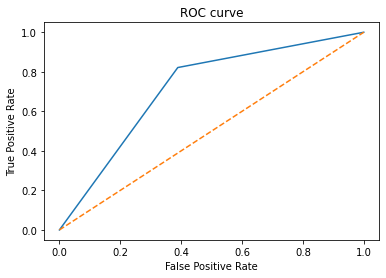

In [24]:
# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

from sklearn.metrics import roc_auc_score

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred)

# Print the AUC score
print("AUC Score:", auc_score)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')  # Plot random guess line
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The AUC score is 0.716, indicating a relatively good performance, clearly performing better than a random classifier. The curve rises relatively steeply and then tends to level off, indicating a model with good discriminatory power. 